# Required Capstone Assignment 20.1: Initial Report and Exploratory Data Analysis (EDA)

**Overview**: In this module, you will work on performing exploratory data analysis (EDA) to develop an initial report for your capstone project. You will use EDA to see what data can reveal beyond the formal modeling, hypothesis testing task, and data training to provide a better understanding of dataset variables and the relationships between them. You are encouraged to spend your time in this module cleaning your data and use feature engineering and EDA techniques to create visualizations to make sense of your findings. Additionally, you will also be required to use one of the ML algorithms you have learned so far in the program to develop a baseline model to use as a comparison in Module 24. You will have time in Module 24 to include additional models, clean the code, and make your work presentable for technical and non-technical audiences. For now, you will do the ‘heavy lifting’ of finding the answer to your research question.

<a id="top"></a>

## Table of Contents
1. [Introduction](#Introduction)
2. [Research Question](#Research-Question)
3. [Data Understanding](#2.-Data-Understanding) 
4. [Data Preparation](#3.-Data-Preparation)
5. [Modeling](#4.-Modeling)
6. [Evaluation](#5.-Evaluation)
7. [Deployment](#6.-Deployment)
8. [Recommendation](#7.-Recommendation)

### Introduction
<!-- ### 1. Business Understanding -->
Identify machine learning models capable of predicting motor_UPDRS values from voice-derived features highlighting features predicting Parkinson.


### Research Question
Can voice-based biomarkers be used to accurately predict Parkinson’s disease (severity according to UPDRS) using supervised machine learning techniques?

### Data Loading & Description
We will be leveraging the Parkinson's Telemonitoring dataset, a publicly available from the UCI Machine Learning Repository. After loading the parkinsons_updrs.csv, we look at its shape to determined how many rows (~5875) there are and further information helps us see how many features (21) there are possible.  The columns are all numerical and our main predictive features are the various jitter, shimmer, and pitch measurements. Our target variables are motor_UPDRS and total_UPDRS.

In [1]:
# core libs
import numpy as np
import pandas as pd

# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score  
from xgboost import XGBRegressor

# presentation
from IPython.display import display, HTML

In [3]:
def load_data(file_path='../data/parkinsons_updrs.csv'):
    data = pd.read_csv(file_path)
    return data

In [5]:
data = load_data()

num_rows = data.shape[0]
print(f"{num_rows:,} total rows")

data.info()

print("\nStatistical Summary:")
print(data.describe())

5,875 total rows
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   floa

## Data Cleaning
The parkinsons_updrs.csv dataset is clean, with no missing values.

In [7]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
subject#         0
age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64


In [9]:
print("\nDuplicates:")
data.duplicated().sum()


Duplicates:


0

## Exploratory Data Analysis (EDA)

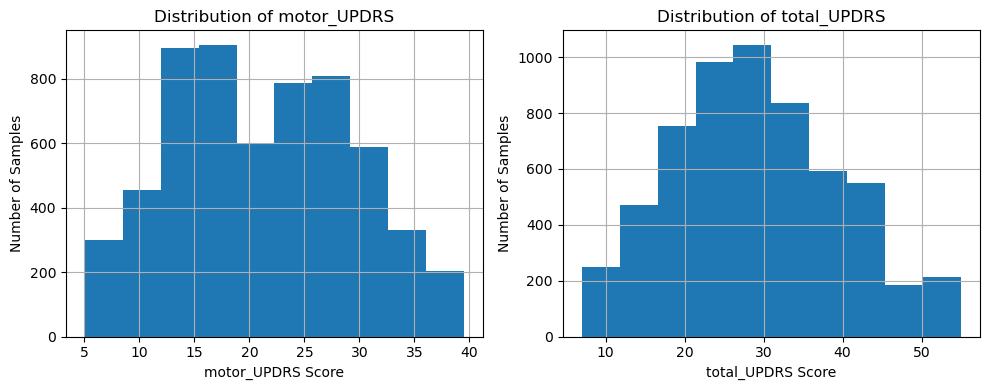

In [13]:
import matplotlib.pyplot as plt

# Plot histograms and capture axes
axes = data[['motor_UPDRS', 'total_UPDRS']].hist(figsize=(10, 4))
plt.tight_layout()

# Add labels and titles
axes[0][0].set_title('Distribution of motor_UPDRS')
axes[0][0].set_xlabel('motor_UPDRS Score')
axes[0][0].set_ylabel('Number of Samples')

axes[0][1].set_title('Distribution of total_UPDRS')
axes[0][1].set_xlabel('total_UPDRS Score')
axes[0][1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Feature Correlation Heatmap')

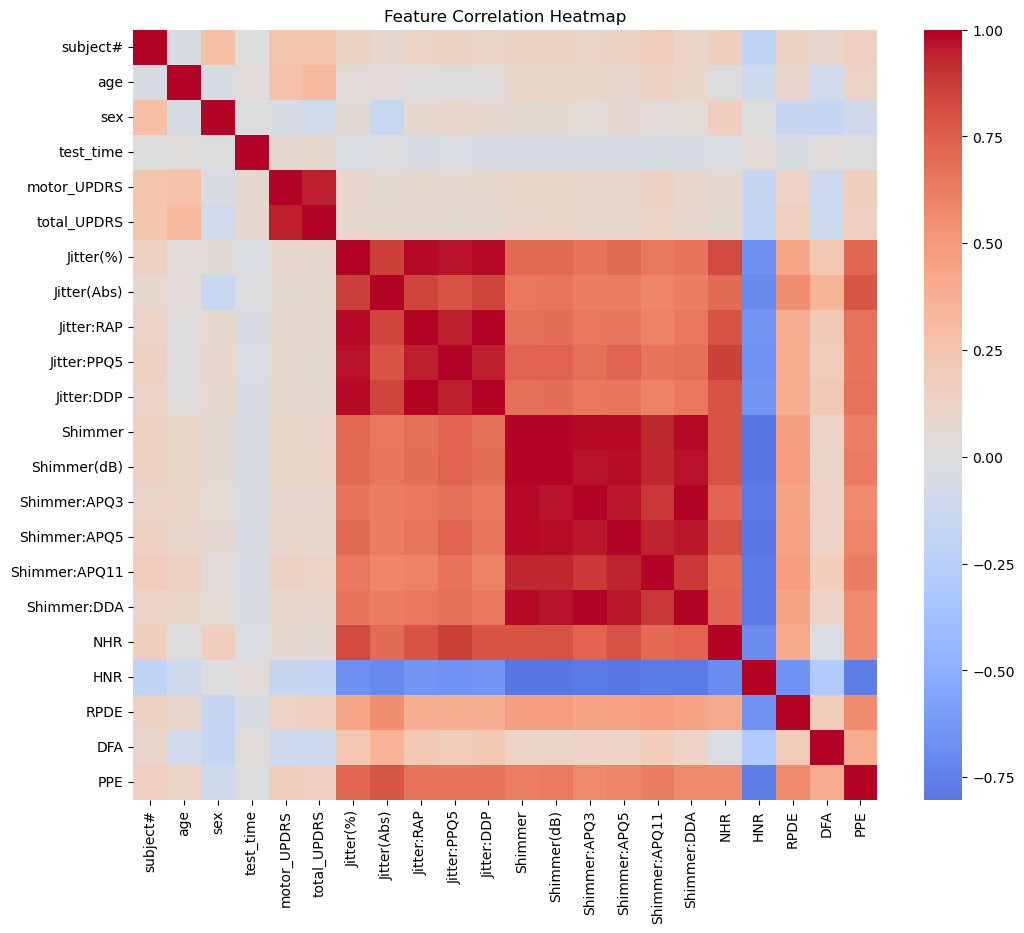

In [15]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Heatmap')

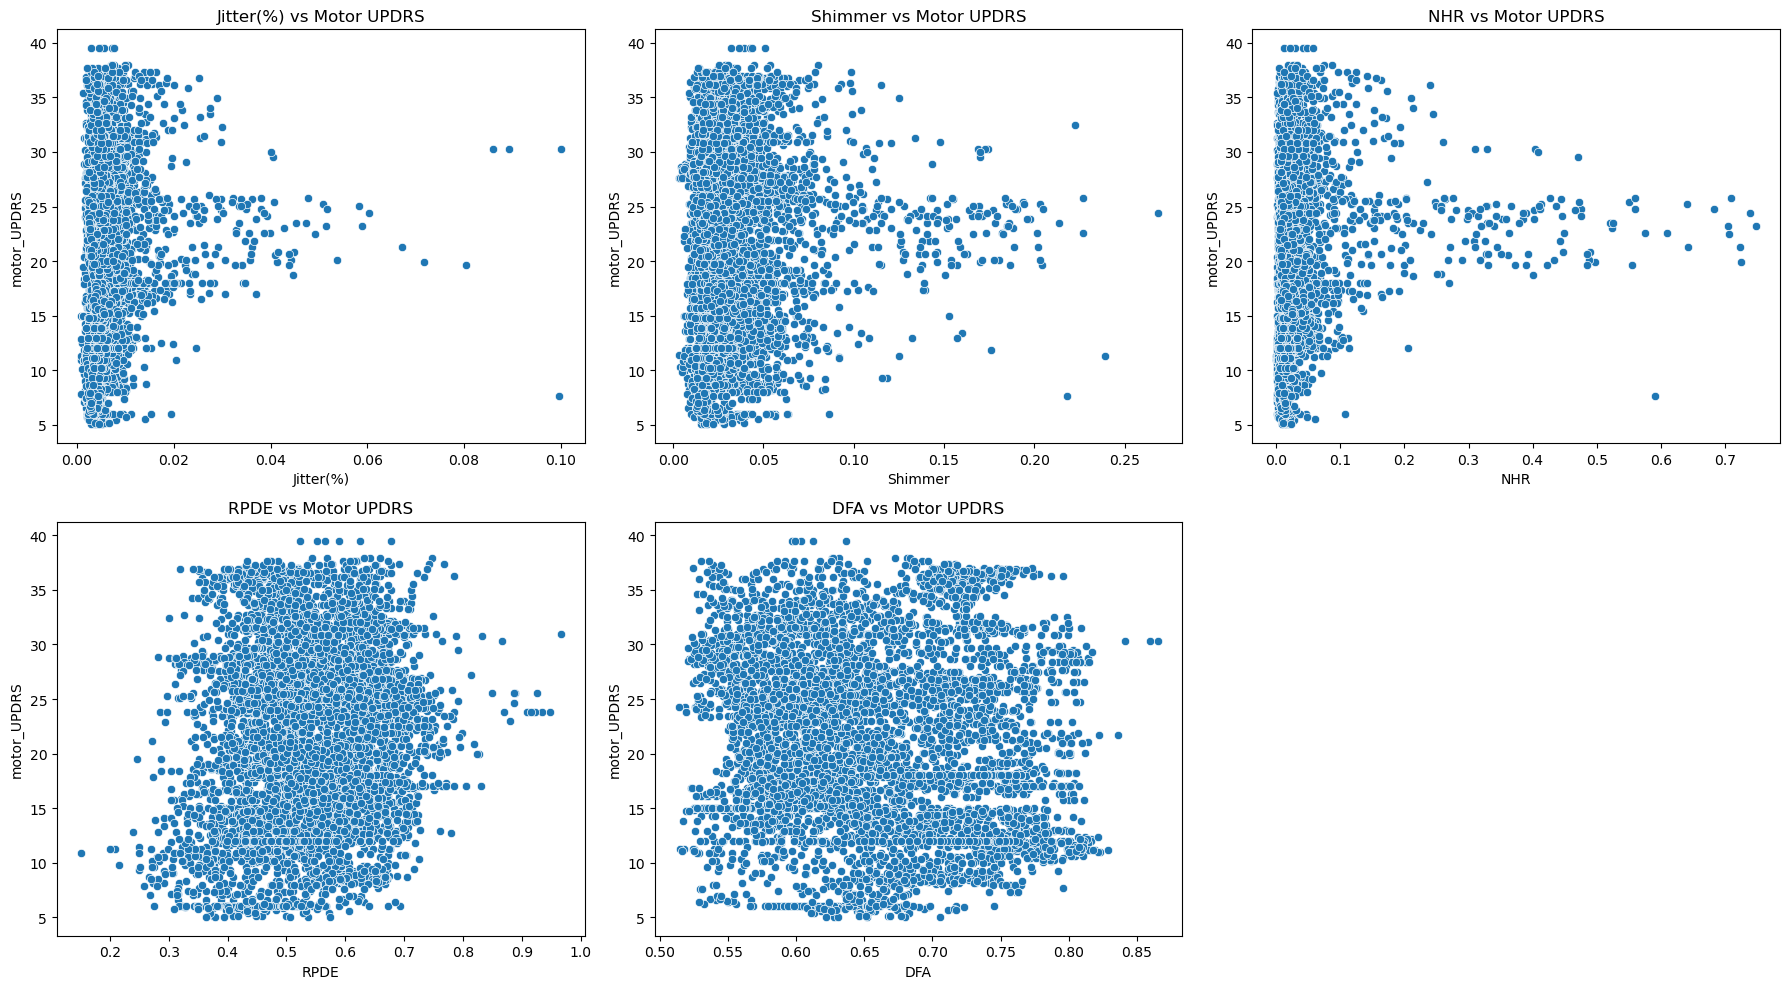

In [17]:
#  scatterplots between features and motor_UPDRS
selected_features = ['Jitter(%)', 'Shimmer', 'NHR', 'RPDE', 'DFA']

# scatterplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, feature in enumerate(selected_features):
    sns.scatterplot(x=feature, y='motor_UPDRS', data=data, ax=axs[i])
    axs[i].set_title(f'{feature} vs Motor UPDRS')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('motor_UPDRS')

# Remove unused subplots
for j in range(len(selected_features), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


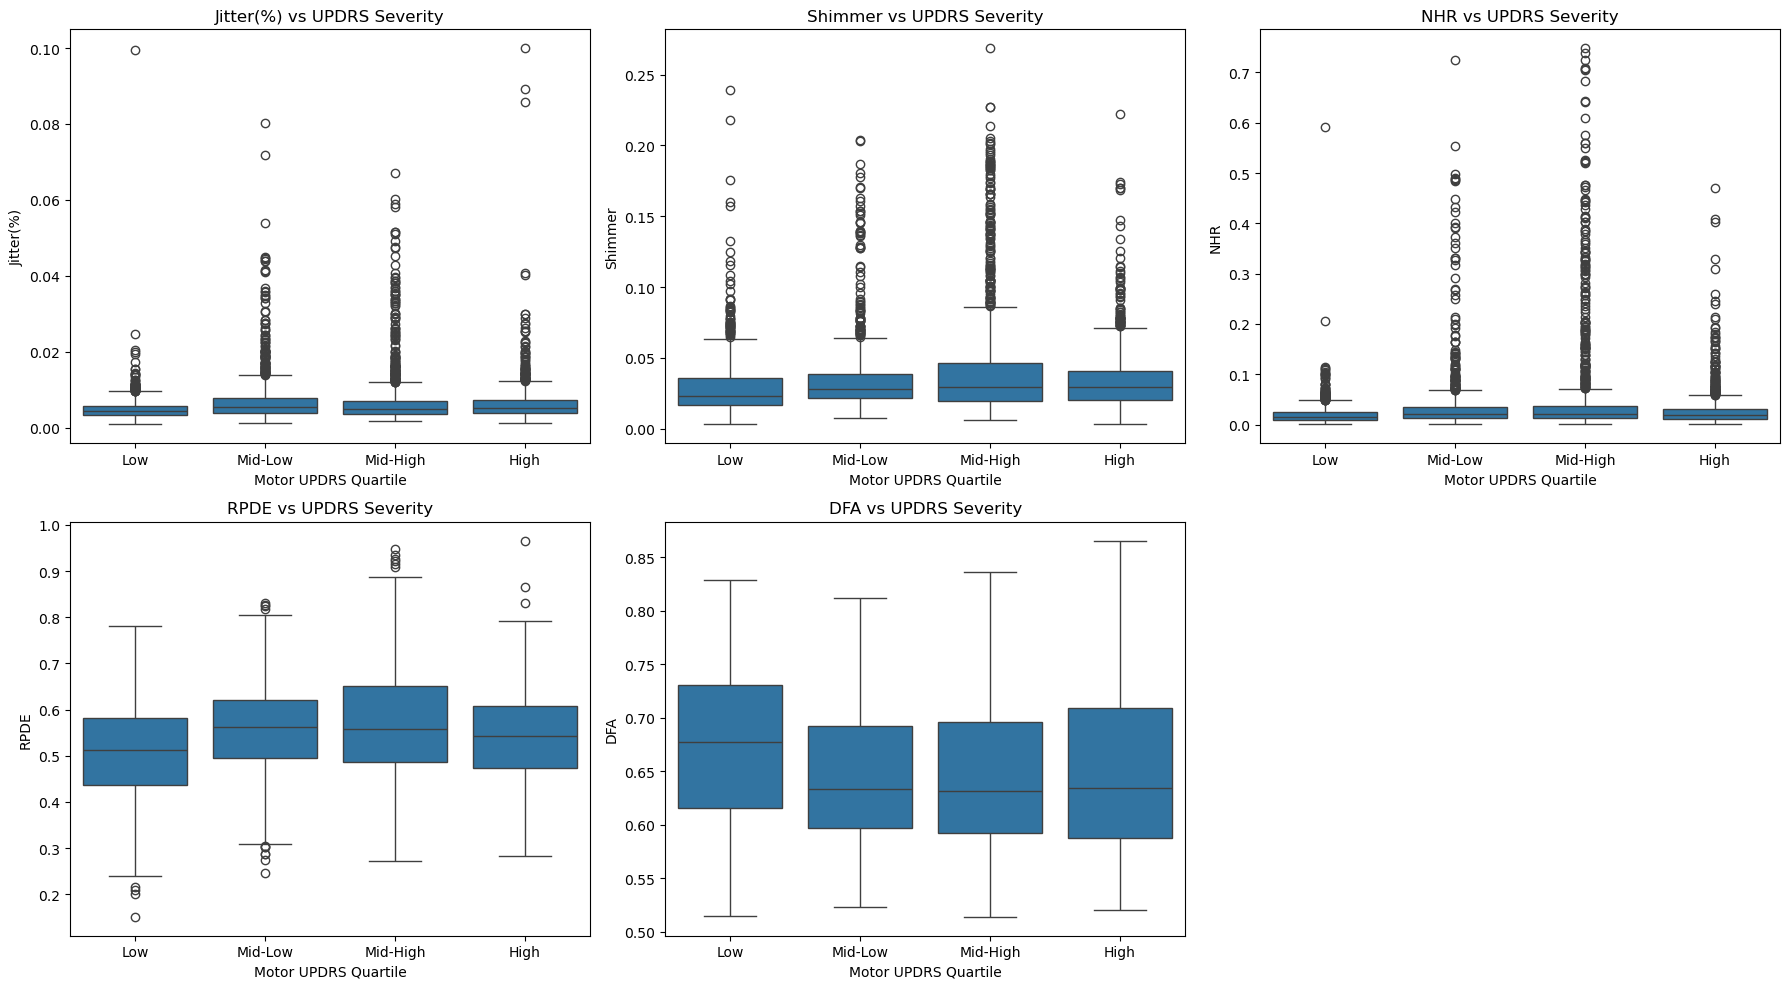

In [19]:
# key features for EDA boxplots
key_features = ['Jitter(%)', 'Shimmer', 'NHR', 'RPDE', 'DFA']
target = 'motor_UPDRS'

# boxplots for selected features vs motor_UPDRS bins
data['UPDRS_bin'] = pd.qcut(data[target], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

# boxplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, feature in enumerate(key_features):
    sns.boxplot(x='UPDRS_bin', y=feature, data=data, ax=axs[i])
    axs[i].set_title(f'{feature} vs UPDRS Severity')
    axs[i].set_xlabel('Motor UPDRS Quartile')
    axs[i].set_ylabel(feature)

# unused subplots
for j in range(len(key_features), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

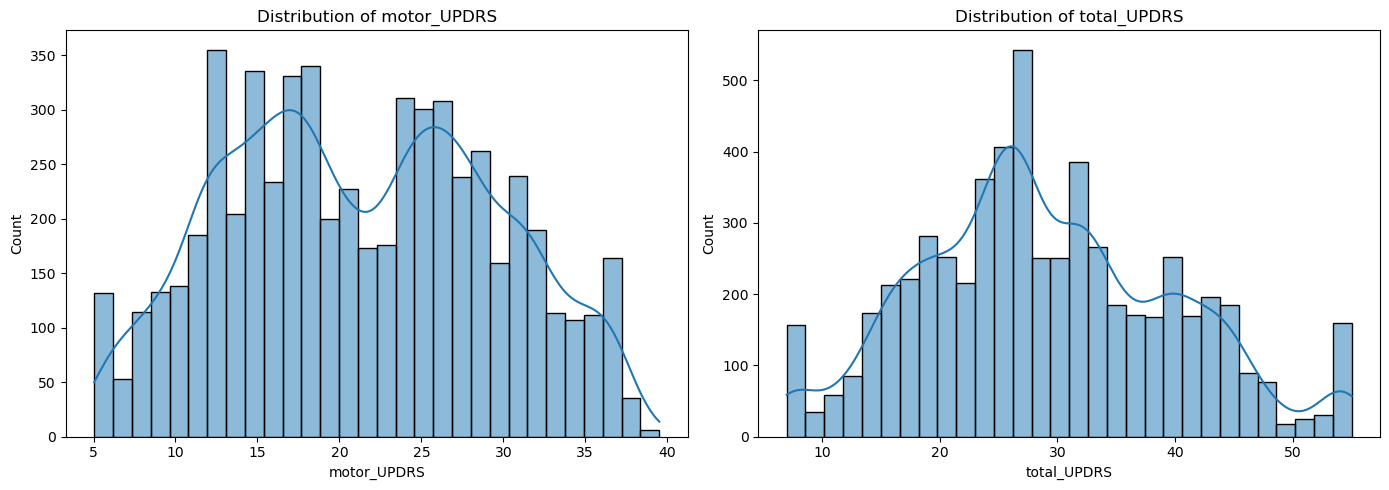

In [21]:
# Plot histograms of the target values: motor_UPDRS and total_UPDRS
fig, axs = plt.subplots(ncols=2, figsize=(14, 5))

sns.histplot(data['motor_UPDRS'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('Distribution of motor_UPDRS')
axs[0].set_xlabel('motor_UPDRS')

sns.histplot(data['total_UPDRS'], bins=30, kde=True, ax=axs[1])
axs[1].set_title('Distribution of total_UPDRS')
axs[1].set_xlabel('total_UPDRS')

plt.tight_layout()
plt.show()


## Baseline Modeling: Linear Regression

In [23]:
X = data.drop(columns=['subject#', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'UPDRS_bin'])
y = data['motor_UPDRS']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train a baseline Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [25]:
# predictions
y_pred = lr_model.predict(X_test)

# evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [27]:

# evaluate
lr_rmse = root_mean_squared_error(y_test, y_pred )
lr_r2 = r2_score(y_test, y_pred)

print("\n--- Linear Regression Results ---")
print(f'RMSE: {lr_rmse:.2f}')
print(f'R²: {lr_r2:.2f}')


--- Linear Regression Results ---
RMSE: 7.51
R²: 0.12


In [29]:
X_used = X_train.copy()

coefficients = pd.Series(lr_model.coef_, index=X_used.columns)

sorted_coeffs = coefficients.abs().sort_values(ascending=False)

print("\nTop 5 Most Impactful Features (Linear Regression Coefficients):")
print(coefficients[sorted_coeffs.head(5).index].to_frame('Coefficient Value'))



Top 5 Most Impactful Features (Linear Regression Coefficients):
              Coefficient Value
Jitter(Abs)       -66001.250778
Jitter:RAP        -25587.095791
Shimmer:APQ3      -17517.867776
Jitter:DDP          8706.738597
Shimmer:DDA         5792.474500


## Feature Engineering 

In [31]:
# Create a new feature: Jitter_Shimmer_Ratio
data['Jitter_Shimmer_Ratio'] = data['Jitter(Abs)'] / data['Shimmer']

# Add the new feature to the feature matrix
X['Jitter_Shimmer_Ratio'] = data['Jitter_Shimmer_Ratio']

# Check correlation with the target
correlation = data[['Jitter_Shimmer_Ratio', 'motor_UPDRS']].corr().iloc[0, 1]
correlation



-0.03542812330613325

In [33]:
# Features
# predict motor_UPDRS
features = data.drop(columns=['subject#', 'age', 'sex', 'test_time', 'UPDRS_bin', 'total_UPDRS', 'motor_UPDRS'])
target = data['motor_UPDRS']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Build and Train the Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate the Model
rf_predictions = rf_model.predict(X_test)
mse = root_mean_squared_error(y_test, rf_predictions)
r2 = r2_score(y_test, rf_predictions)

print(f"\nModel Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Get Feature Importances
importances = pd.Series(rf_model.feature_importances_, index=features.columns).sort_values(ascending=False)
print("\nTop 5 Most Important Features:")
print(importances.head(5))


Model Performance:
Mean Squared Error (MSE): 6.52
R-squared (R²): 0.33

Top 5 Most Important Features:
DFA            0.153890
HNR            0.120879
PPE            0.099143
RPDE           0.086455
Jitter(Abs)    0.075176
dtype: float64


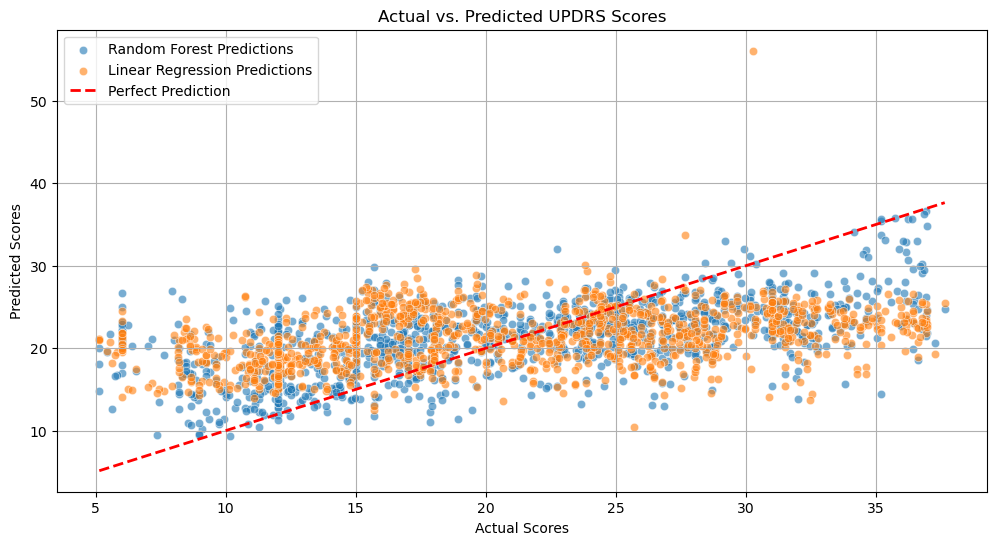

In [35]:
# Visual Comparison of Prediction
plt.figure(figsize=(12, 6))

# Scatter plot of actual vs. predicted values
sns.scatterplot(x=y_test, y=rf_predictions, alpha=0.6, label='Random Forest Predictions')
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label='Linear Regression Predictions')

# Line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Prediction')

plt.title('Actual vs. Predicted UPDRS Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.legend()
plt.grid(True)
plt.show()


## Conclusion

This baseline model will be compared against more advanced models in Module 24.
RMSE and R² provide a quantitative benchmark for severity prediction performance.
Future steps will include hyperparameter tuning and comparing tree-based regressors.